# PyTorch实例1：MNIST图像分类
作者：杨邦

邮箱：yangbang@pku.edu.cn

日期：2022-09-28

## 1.1 导入可能需要用的工具包

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt

## 1.2 数据准备

In [2]:
# 将数据从numpy转变成张量tensor
transform = transforms.Compose(
    [transforms.ToTensor()]
)
# 获取数据，若不存在于指定目录中，则下载
train_data = datasets.MNIST(
    root="./data",  
    transform=transform, 
    train=True, 
    download=True 
    # 自动下载数据，包括了训练集和测试集
)
test_data = datasets.MNIST(
    root="./data", 
    transform=transform, 
    train=False
)
print(train_data)
print(test_data)

9920512it [00:02, 4453206.91it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 47721.61it/s]                            


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 1539341.40it/s]                             


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 16318.17it/s]            
/Users/yangbang/opt/anaconda3/envs/vc/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## 1.3 数据加载器定义

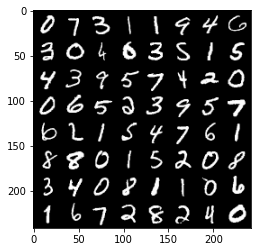

In [3]:
batch_size = 64

# 定义用于读取数据的加载器
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = False
)

# 可视化看看
images,labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
grid = grid.permute(1, 2, 0)
plt.imshow(grid)
plt.show()

## 1.4 模型定义

In [4]:
class Naive_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dense = nn.Linear(1 * 28 * 28, 10)
        
    def forward(self,x):
        # x: (batch_size, 1, 28, 28) 输入为灰度图，单通道，分辨率为28*28
        x = x.view(x.size(0), -1) # (batch_size, 1*28*28)
        x = self.dense(x)         # (batch_size, 10)
        return x


class Conv_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            # 卷积核（滤波器）大小为3*3，共32个卷积核；
            # 由于stride和padding的缘故，卷积后特征图大小不变（保持28*28）
            # 具体可查询卷积层特征图的大小计算公式
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            # 池化(pooling)层，这里实现了两倍的下采样，即分辨率从28*28，下降到14*14
            nn.MaxPool2d(stride=2, kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            # 卷积核（滤波器）大小为3*3，共64个卷积核；卷积后特征图大小不变（保持14*14）
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 池化(pooling)层，这里实现了两倍的下采样，即分辨率从14*14，下降到7*7
            nn.MaxPool2d(stride=2, kernel_size=2),
        )
        self.dense = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.Dropout(0.5),
            nn.Linear(128,10)
        )
        
    def forward(self,x):
        # x: (batch_size, 1, 28, 28)
        x = self.conv1(x)  # (batch_size, 32, 14, 14)
        x = self.conv2(x)  # (batch_size, 64, 7, 7)
        x = x.view(x.size(0),-1) # (batch_size, 64 * 7 * 7)
        x = self.dense(x)  # (batch_size, 10)
        return x

## 1.5 训练/测试函数定义

In [5]:
class AverageMeter(object):
    """
    用于储存与计算平均值
    """ 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1, multiply=True):
        self.val = val
        if multiply:
            self.sum += val * n
        else:
            self.sum += val
        self.count += n
        self.avg = self.sum / self.count

def training(model, loader, crit, optim, device):
    # 模型调成训练模式
    model.train()
    # 模型移到指定设备
    model.to(device)
    # 用于记录损失和正确率
    meter_loss, meter_acc = AverageMeter(), AverageMeter()
    
    for data in loader:
        # 清空梯度
        optim.zero_grad()
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        # 计算损失
        loss = crit(outputs, labels)
        # 反向传播，计算梯度
        loss.backward()
        # 更新网络参数
        optim.step()
        
        # 记录损失
        num_sample = inputs.size(0)
        meter_loss.update(loss.item(), num_sample)
        # 记录预测正确率
        preds = outputs.max(dim=1)[1] # 网络预测的类别结果
        correct = (preds == labels).sum() # 计算预测的正确个数
        meter_acc.update(correct.item(), num_sample, multiply=False)
    
    # 返回平均损失和平均正确率
    return meter_loss.avg, meter_acc.avg

@torch.no_grad()
def evaluate(model, loader, device):
    # 模型调成评估模式
    model.eval()
    # 模型移到指定设备
    model.to(device)
    # 用于记录正确率
    meter_acc = AverageMeter()
    for data in loader:
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        # 记录预测正确率
        num_sample = inputs.size(0)
        preds = outputs.max(dim=1)[1] # 网络预测的类别结果
        correct = (preds == labels).sum() # 计算预测的正确个数
        meter_acc.update(correct.item(), num_sample, multiply=False)
    
    # 返回平均正确率
    return meter_acc.avg

## 1.6 运行

### 1.6.1 使用简单模型（只有一层全连接层）

In [6]:
# 定义一些参数
n_epochs = 5 # 要训练多少轮

# 定义设备，安装了cuda，可以使用GPU加速
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 实例化模型
naive_model = Naive_Model()
# 选定评判准则（损失函数）
crit = torch.nn.CrossEntropyLoss()
# 选定优化器
optim = torch.optim.Adam(naive_model.parameters())

# 打印模型
print(naive_model)

print('Start running!')
for epoch in range(n_epochs):
    # 训练
    train_loss, train_acc = training(naive_model, train_loader, crit, optim, device)
    # 测试
    test_acc = evaluate(naive_model, test_loader, device)
    # 打印信息
    print('|Epoch {}/{}\t Train Loss: {:.2f}\tTrain Acc: {:.2f}\tTest Acc: {:.2f}'.format(
            epoch,
            n_epochs,
            train_loss, 
            100 * train_acc,
            100 * test_acc
    ))
print('Done!')

Naive_Model(
  (dense): Linear(in_features=784, out_features=10, bias=True)
)
Start running!
|Epoch 0/5	 Train Loss: 0.55	Train Acc: 86.77	Test Acc: 91.32
|Epoch 1/5	 Train Loss: 0.32	Train Acc: 91.12	Test Acc: 91.83
|Epoch 2/5	 Train Loss: 0.30	Train Acc: 91.82	Test Acc: 92.09
|Epoch 3/5	 Train Loss: 0.28	Train Acc: 92.13	Test Acc: 92.41
|Epoch 4/5	 Train Loss: 0.27	Train Acc: 92.42	Test Acc: 92.49
Done!


### 1.6.2 使用复杂模型（含卷积层，全连接层等）

In [7]:
# 定义一些参数
n_epochs = 5 # 要训练多少轮

# 定义设备，安装了cuda，可以使用GPU加速
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 定义评判准则（损失函数）
crit = torch.nn.CrossEntropyLoss()

# 定义模型和优化器
conv_model = Conv_Model()
optim = torch.optim.Adam(conv_model.parameters())

# 打印模型
print(conv_model)

#开始运行
print('Start running!')
for epoch in range(n_epochs):
    # 训练
    train_loss, train_acc = training(conv_model, train_loader, crit, optim, device)
    # 测试
    test_acc = evaluate(conv_model, test_loader, device)
    # 打印信息
    print('|Epoch {}/{}\t Train Loss: {:.2f}\tTrain Acc: {:.2f}\tTest Acc: {:.2f}'.format(
            epoch,
            n_epochs,
            train_loss, 
            100 * train_acc,
            100 * test_acc
    ))
print('Done!')

Conv_Model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
Start running!
|Epoch 0/5	 Train Loss: 0.18	Train Acc: 94.51	Test Acc: 98.56
|Epoch 1/5	 Train Loss: 0.06	Train Acc: 98.08	Test Acc: 98.49
|Epoch 2/5	 Train Loss: 0.05	Train Acc: 98.47	Test Acc: 98.77
|Epoch 3/5	 Train Loss: 0.04	Train Acc: 98.76	Test Acc: 99.07
|Epoch 4/5	 Train Loss: 0.03	Train Acc: 99.04	Test Acc: 98.96
Done!


## 1.7 可视化 -- 混淆矩阵

### 1.7.1定义函数

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def compute_confusion_matrix(preds, labels, num_class=10):
    """
    计算混淆矩阵
        - preds: 网络预测结果
        - labels: 真实标签
        - num_class: 类别数目
    返回[num_class, num_class]方阵
    """
    conf_matrix = torch.zeros(num_class, num_class)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    绘制混淆矩阵
        - cm: 混淆矩阵，shape like [N, N]
        - classses: 类别列表, len(classes) = N
        - normalize: True(归一化)，False(绝对值)
        - title: 图的标题名字
        - cmap: 使用哪种类型的渐变色
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig = plt.gcf()
    fig.set_size_inches(6, 5)
    

def get_preds_labels(model, loader, device):
    model.to(device)
    # 模型调成评估模式
    model.eval()
    all_preds, all_labels = [], []
    for data in loader:
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        # 获得网络预测的类别结果
        preds = outputs.max(dim=1)[1] 
        # 收集数据
        all_preds.append(preds)
        all_labels.append(labels)
    return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)

### 1.7.2 获得数据并绘制

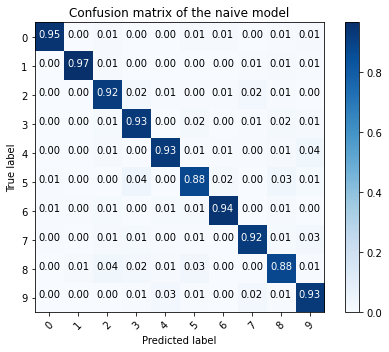

In [9]:
preds, labels = get_preds_labels(naive_model, test_loader, device)
cnf_matrix = compute_confusion_matrix(preds, labels, num_class=10)
classes = ['%d' % i for i in range(10)]
plot_confusion_matrix(cnf_matrix.numpy(), classes=classes, normalize=True, title='Confusion matrix of the naive model')

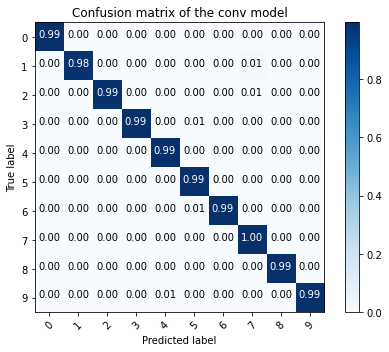

In [10]:
preds, labels = get_preds_labels(conv_model, test_loader, device)
cnf_matrix = compute_confusion_matrix(preds, labels, num_class=10)
classes = ['%d' % i for i in range(10)]
plot_confusion_matrix(cnf_matrix.numpy(), classes=classes, normalize=True, title='Confusion matrix of the conv model')

# 传统模型

In [11]:
train_images = torch.stack([item[0] for item in train_data], dim=0) # (60000, 1, 28, 28)
train_images = train_images.view(train_images.size(0), -1).numpy() # (60000, 1 * 28 * 28)
train_labels = np.array([item[1] for item in train_data]) # (60000,)

test_images = torch.stack([item[0] for item in test_data], dim=0) # (10000, 1, 28, 28)
test_images = test_images.view(test_images.size(0), -1).numpy() # (10000, 1 * 28 * 28)
test_labels = np.array([item[1] for item in test_data])

## 决策树

In [12]:
import sklearn.tree as st

model = st.DecisionTreeClassifier()
model.fit(train_images, train_labels)
predictions = model.predict(test_images)

num_correct = (predictions == test_labels).sum()
num_total = test_labels.shape[0]
print('Accuracy of the decision tree: {:.3f}'.format(
    num_correct / num_total
))

Accuracy of the decision tree: 0.877


## 随机森林

In [13]:
import sklearn.ensemble as se
import warnings
warnings.filterwarnings("ignore")

for num_trees in [2, 5, 10, 20, 50, 100]:
    model = se.RandomForestClassifier(n_estimators=num_trees)
    model.fit(train_images, train_labels)
    predictions = model.predict(test_images)

    num_correct = (predictions == test_labels).sum()
    num_total = test_labels.shape[0]
    print('Accuracy of the random forest ({} trees): {}'.format(
        num_trees, 
        num_correct / num_total
    ))
    

Accuracy of the random forest (2 trees): 0.814
Accuracy of the random forest (5 trees): 0.9226
Accuracy of the random forest (10 trees): 0.9473
Accuracy of the random forest (20 trees): 0.9608
Accuracy of the random forest (50 trees): 0.968
Accuracy of the random forest (100 trees): 0.9704
